<a href="https://colab.research.google.com/github/dsmgoooner/US-Economic-Indicators-Analysis/blob/main/US_Economic_Indicator_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fredapi > /dev/null

# Importing Libraries

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
cplor_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

from fredapi import Fred

fred_key = 'd4f9839301f7d3cfd3241805dd487914'

# 1. Create The Fred Object



In [ ]:
fred = Fred(api_key=fred_key)

# 2. Search for Economic data

In [104]:
sp_search = fred.search('S&P', order_by='popularity')
sp_search.shape

(1000, 15)

# 3. Pull Raw Data

<Axes: title={'center': 'S&P 500 Index'}>

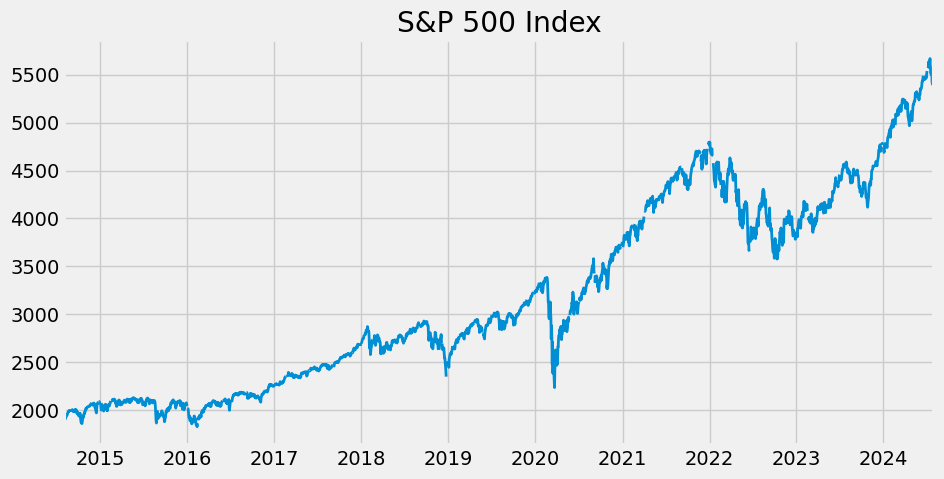

In [105]:
sp500 = fred.get_series(series_id='SP500')
sp500.plot(figsize=(10, 5), title='S&P 500 Index', lw = 2)

# 4. Pull and Join Multiple Data Series

In [ ]:
uemp_results = fred.search('unemployment')

In [ ]:
uemp_results

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
UNRATE,UNRATE,2024-08-03,2024-08-03,Unemployment Rate,1948-01-01,2024-07-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2024-08-02 07:46:02-05:00,95,The unemployment rate represents the number of...
UNRATENSA,UNRATENSA,2024-08-03,2024-08-03,Unemployment Rate,1948-01-01,2024-07-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2024-08-02 07:46:07-05:00,58,The unemployment rate represents the number of...
UNEMPLOY,UNEMPLOY,2024-08-03,2024-08-03,Unemployment Level,1948-01-01,2024-07-01,Monthly,M,Thousands of Persons,Thous. of Persons,Seasonally Adjusted,SA,2024-08-02 07:46:03-05:00,71,The series comes from the 'Current Population ...
NROU,NROU,2024-08-03,2024-08-03,Noncyclical Rate of Unemployment,1949-01-01,2034-10-01,Quarterly,Q,Percent,%,Not Seasonally Adjusted,NSA,2024-07-01 12:01:04-05:00,69,"Starting with the July, 2021 report: An Update..."
CCSA,CCSA,2024-08-03,2024-08-03,Continued Claims (Insured Unemployment),1967-01-07,2024-07-20,"Weekly, Ending Saturday",W,Number,Number,Seasonally Adjusted,SA,2024-08-01 07:33:04-05:00,74,"Continued claims, also referred to as insured ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LAUCN340030000000003A,LAUCN340030000000003A,2024-08-03,2024-08-03,"Unemployment Rate in Bergen County, NJ",1990-01-01,2023-01-01,Annual,A,Percent,%,Not Seasonally Adjusted,NSA,2024-05-01 10:48:38-05:00,0,These data come from the Current Population Su...
LMUNRRTTLUM156S,LMUNRRTTLUM156S,2024-08-03,2024-08-03,Infra-Annual Registered Unemployment and Job V...,1995-01-01,2023-12-01,Monthly,M,Growth rate previous period,Growth rate previous period,Seasonally Adjusted,SA,2024-04-10 11:07:38-05:00,5,OECD Data Filters: REF_AREA: LUX MEASURE: REG...
LNS14000315,LNS14000315,2024-08-03,2024-08-03,Unemployment Rate - Married Women,1955-01-01,2024-07-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2024-08-02 07:46:34-05:00,9,To obtain estimates of women worker employment...


<Axes: >

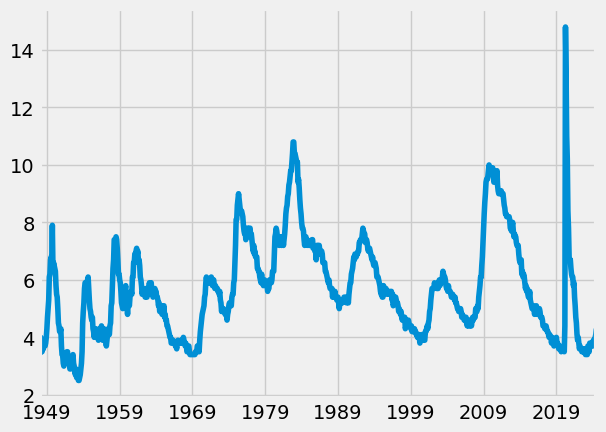

In [106]:
unrate = fred.get_series(series_id='UNRATE')
unrate.plot()

In [ ]:
unemp_df = fred.search('unemployment_state', filter = ('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [99]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Don't request to fast and get blocked
uemp_results = pd.concat(all_results, axis=1)

In [100]:
cols_to_drop = []
for i in uemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
uemp_results = uemp_results.drop(columns = cols_to_drop, axis=1)

In [101]:
uemp_states = uemp_results.copy()  #.drop('UNRATE', axis=1)
uemp_states = uemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

In [102]:
# Plot States Unemployment Rate
px.line(uemp_states)

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



# 5. April 2020 Unemployment Rate per State

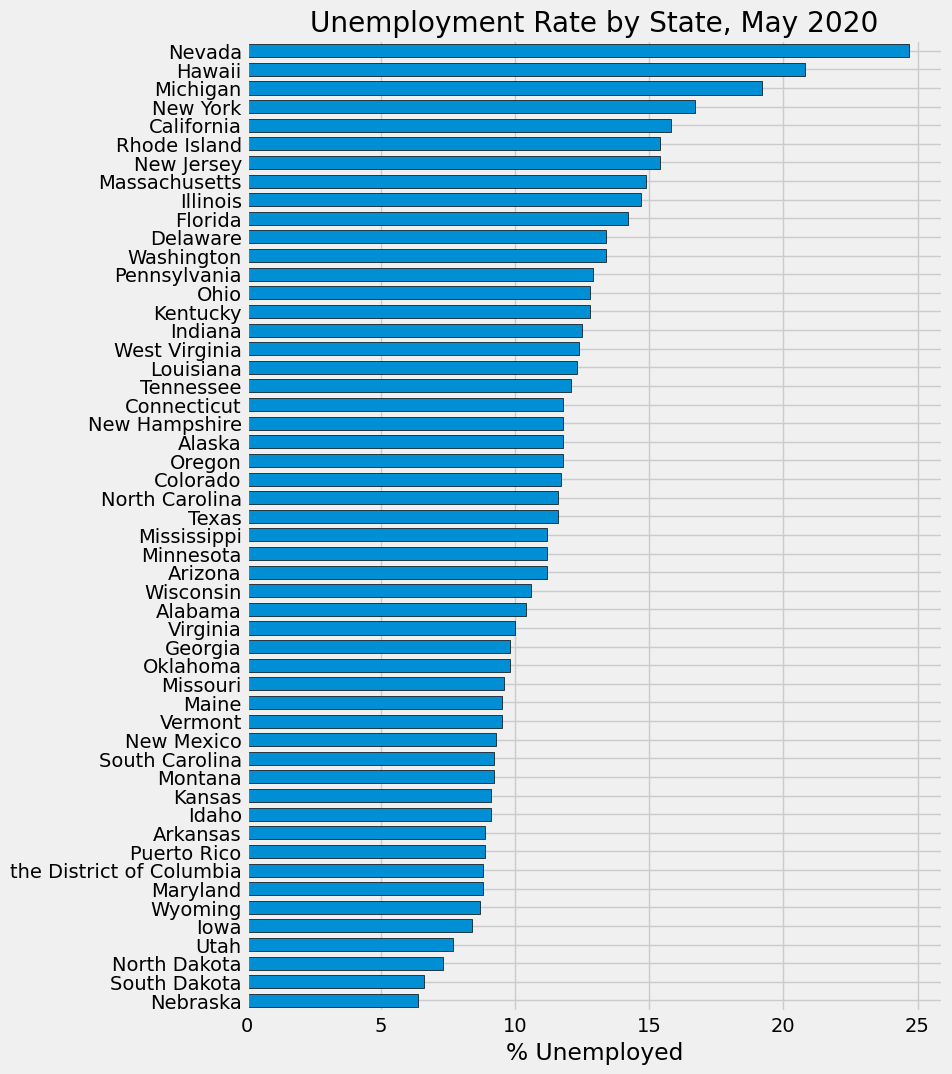

In [103]:
ax = uemp_states.loc[uemp_states.index == '2020-05-01'].T \
    .sort_values('2020-05-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, May 2020')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.show()